### All Imports in one place

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms.functional as functional
from tqdm import tqdm
import numpy as np
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random

### Device Selection

In [2]:
device = None

if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f'Available device is {device}')

Available device is cuda


### Constants declaration

In [3]:
BATCH_SIZE = 32
EPOCHS = 5

### Define the neural network
Taken from https://github.com/pytorch/examples/blob/main/mnist/main.py

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


### Use a helper class to simulate a client

In [14]:
class Client:
    def __init__(self, transform, device, description, model=None, dataset_test=None):
        self.device = device

        self.dataset_train = datasets.MNIST('../dataset', train=True, download=True,
                                            transform=transform)

        self.dataset_test = dataset_test
        if dataset_test is None:
            self.dataset_test = datasets.MNIST('../dataset', train=False,
                                               transform=transform)

        self.train_loader = torch.utils.data.DataLoader(self.dataset_train, batch_size=BATCH_SIZE, shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(self.dataset_test, batch_size=1, shuffle=True)

        self.model = Net().to(device)

        if model is not None:
            self.model = model

        self.description = description
        self.cluster_id = -1

    def train(self, optimizer):
        self.train_with(optimizer, self.train_loader)

    def train_with(self, optimizer, train_loader):
        model = self.model

        model.train()
        for data, target in tqdm(train_loader, desc=f"Training Client \"{self.description}\"", disable=True):
            data, target = data.to(self.device), target.to(self.device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            # if batch_idx % 50 == 0:
            #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            #         epoch, batch_idx * len(data), len(self.train_loader.dataset),
            #         100. * batch_idx / len(self.train_loader), loss.item()))

    def test(self):
        self.test_with(self.test_loader)

    def test_with(self, test_loader):
        model = self.model
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in tqdm(test_loader, desc=f"Testing Client \"{self.description}\"", disable=True):
                data, target = data.to(self.device), target.to(self.device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)

        print(
            f"Test set for Client \"{self.description}\": Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)")

    def get_training_sample_amount(self):
        return len(self.train_loader.dataset)

### Transformations for the dataset

In [6]:
class FixedRotation:
    def __init__(self, angle):
        self.angle = angle

    def __call__(self, img):
        return functional.rotate(img, self.angle)


class RandomRotationRange:
    def __init__(self, angle_begin, angle_end):
        self.angle_begin = angle_begin
        self.angle_end = angle_end

    def __call__(self, img):
        angle = random.uniform(self.angle_begin, self.angle_end)
        return functional.rotate(img, angle)


DEFAULT_TRANSFORM = [
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]


def default_transform_fixed(rotation_angle):
    return transforms.Compose([FixedRotation(rotation_angle)] + DEFAULT_TRANSFORM)


def default_transform_random(angle_begin, angle_end):
    return transforms.Compose([RandomRotationRange(angle_begin, angle_end)] + DEFAULT_TRANSFORM)

### Some helper methods to perform federated learning

In [7]:
def federated_average(global_model, models, data_sizes):
    total_data = sum(data_sizes)

    with torch.no_grad():
        for key in global_model.state_dict().keys():
            global_model.state_dict()[key].zero_()
            for i, model in enumerate(models):
                global_model.state_dict()[key] += (model.state_dict()[key] * (data_sizes[i] / total_data))

    return global_model


def distribute_model(model, clients):
    for client in clients:
        client.model.load_state_dict(model.state_dict())


def get_model_updates(global_model, client_model):
    updates = []
    for key in global_model.state_dict().keys():
        diff = client_model.state_dict()[key] - global_model.state_dict()[key]
        updates.append(diff.flatten())
    return torch.cat(updates).cpu().numpy()


def reduce_dimensions(updates):
    pca = PCA(n_components=2)
    reduced_updates = pca.fit_transform(updates)
    return reduced_updates


def select_best_model(models, input_image):
    best_model = None
    best_loss = float("inf")

    with torch.no_grad():
        for model in models:
            output = model(input_image)
            prob = F.softmax(output, dim=-1)
            loss = -torch.max(prob)

            if loss < best_loss:
                best_loss = loss
                best_model = model

    return best_model


### Method to visualize the model updates

In [8]:
def visualize_model_updates(reduced_data, labels, epoch):
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1],
                c=labels, cmap='viridis', s=100, edgecolors='k')

    unique_labels = np.unique(labels)
    cmap = plt.colormaps.get_cmap('viridis')
    norm_factor = max(unique_labels) if len(unique_labels) > 0 else 1

    handles = []
    for label in unique_labels:
        color = cmap(label / norm_factor)
        handles.append(mpatches.Patch(color=color, label=f'Cluster {label}'))
    plt.legend(handles=handles, title='Cluster')

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Clustered Clients at Epoch ' + str(epoch))
    plt.show()

### Setup for Training, Testing and Clustering

In [18]:
ALL_CLIENTS = []


def add_clients_in_range(angle_begin, angle_end, amount, clients):
    for i in range(amount):
        angle = random.uniform(angle_begin, angle_end)
        clients.append(
            Client(default_transform_fixed(angle), device, f"Rotation {angle:.0f} (Group {angle_begin}-{angle_end})"))


add_clients_in_range(0, 360, 15, ALL_CLIENTS)

combined_dataset_test = datasets.MNIST('../dataset', train=False, download=True,
                                       transform=default_transform_random(0, 360))

global_model = Net().to(device)
distribute_model(global_model, ALL_CLIENTS)

num_clients = len(ALL_CLIENTS)
cluster_models = {}
prev_labels = None


def test_best_cluster():
    test_loader = torch.utils.data.DataLoader(combined_dataset_test, batch_size=1, shuffle=True)
    with torch.no_grad():
        test_loss = 0
        correct = 0

        for data, target in tqdm(test_loader, desc="Testing best models using cluster", disable=True):
            selected_model = select_best_model([client.model for client in ALL_CLIENTS], data.to(device))

            data, target = data.to(device), target.to(device)
            selected_model.eval()
            output = selected_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('Test set for best model / cluster: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset))
        )

### Abstract Class that contains the workflow for training, testing and clustering without explicit cluster algorithms

In [20]:
class AbstractClusteringTrainer:
    def __init__(self, global_model, clients, epochs, clustering_interval=1, dont_cluster=False):
        self.global_model = global_model
        self.clients = clients
        self.epochs = epochs
        self.clustering_interval = clustering_interval
        self.cluster_models = {}
        self.prev_labels = None
        self.dont_cluster = dont_cluster
        self.reduced_dimensions = None

    def train_all_epochs(self):
        for epoch in range(1, self.epochs + 1):
            print(f"\n============== EPOCH {epoch} ==============\n")
            new_client_models = []
            for client in self.clients:
                if client.cluster_id == -1:
                    assigned_model = self.global_model
                else:
                    assigned_model = self.cluster_models.get(client.cluster_id, self.global_model)
                client.model = copy.deepcopy(assigned_model)
                optimizer = optim.Adadelta(client.model.parameters(), lr=0.001)
                client.train(optimizer)
                new_client_models.append(client.model)
                client.test()

            if not self.dont_cluster and epoch % self.clustering_interval == 0:

                client_updates = [get_model_updates(self.global_model, client.model)
                                  for client in self.clients]
                X = np.array(client_updates)
                reduced_x = reduce_dimensions(X)


                labels = self.cluster(reduced_x)
                unique_clusters = set(labels)

                if self.prev_labels is None or not np.array_equal(self.prev_labels, labels):
                    self.cluster_models = {cluster: copy.deepcopy(self.global_model)
                                           for cluster in unique_clusters if cluster != -1}
                    self.prev_labels = np.copy(labels)
                    print(f"New clusters detected: {labels}")

                    cluster_assignments = {}
                    for i, client in enumerate(ALL_CLIENTS):
                        cluster = labels[i]
                        if cluster not in cluster_assignments:
                            cluster_assignments[cluster] = []
                        cluster_assignments[cluster].append(client.description)

                    print("Cluster breakdown:")
                    for cluster, client_list in cluster_assignments.items():
                        print(f"Cluster {cluster}:")
                        for client_desc in client_list:
                            print(f"   {client_desc}")

                visualize_model_updates(reduced_x, labels, epoch)

                for cluster in self.cluster_models.keys():
                    indices = [i for i, lbl in enumerate(labels) if lbl == cluster]
                    cluster_clients = [new_client_models[i] for i in indices]
                    if cluster_clients:
                        data_sizes = [self.clients[i].get_training_sample_amount() for i in indices]
                        self.cluster_models[cluster] = federated_average(
                            self.cluster_models[cluster], cluster_clients, data_sizes)
                        affected_clients = [self.clients[i] for i in indices]
                        distribute_model(self.cluster_models[cluster], affected_clients)
                        for client in affected_clients:
                            client.cluster_id = cluster

            data_sizes_all = [client.get_training_sample_amount() for client in self.clients]
            self.global_model = federated_average(self.global_model, new_client_models, data_sizes_all)


            combined_client = Client(default_transform_fixed(0), device, "Global Model", self.global_model,
                                     combined_dataset_test)
            combined_client.test()

    def cluster(self, reduced_data):
        raise NotImplementedError("Subclasses must implement this method")

### DBSCAN Clustering

In [21]:
class DBSCANTrainer(AbstractClusteringTrainer):
    def cluster(self, reduced_data):
        dbscan = DBSCAN(eps=0.15, min_samples=1)
        return dbscan.fit_predict(reduced_data)


============== EPOCH 1 ==============

Test set for Client "Rotation 218 (Group 0-360)": Average loss: 1.1487, Accuracy: 8153/10000 (82%)
Test set for Client "Rotation 168 (Group 0-360)": Average loss: 1.1569, Accuracy: 8061/10000 (81%)
Test set for Client "Rotation 30 (Group 0-360)": Average loss: 1.1352, Accuracy: 8163/10000 (82%)
Test set for Client "Rotation 286 (Group 0-360)": Average loss: 1.1624, Accuracy: 8152/10000 (82%)
Test set for Client "Rotation 358 (Group 0-360)": Average loss: 1.1421, Accuracy: 8190/10000 (82%)
Test set for Client "Rotation 195 (Group 0-360)": Average loss: 1.1472, Accuracy: 8128/10000 (81%)
Test set for Client "Rotation 46 (Group 0-360)": Average loss: 1.1063, Accuracy: 8143/10000 (81%)
Test set for Client "Rotation 9 (Group 0-360)": Average loss: 1.1688, Accuracy: 8141/10000 (81%)
Test set for Client "Rotation 190 (Group 0-360)": Average loss: 1.1501, Accuracy: 8108/10000 (81%)
Test set for Client "Rotation 95 (Group 0-360)": Average loss: 1.1707, Ac

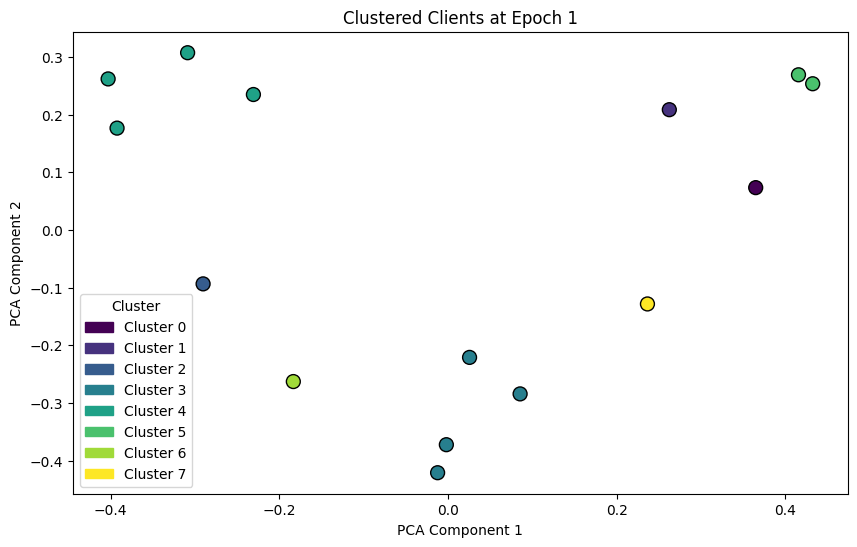

Test set for Client "Global Model": Average loss: 1.9973, Accuracy: 2708/10000 (27%)

============== EPOCH 2 ==============

Test set for Client "Rotation 218 (Group 0-360)": Average loss: 0.5563, Accuracy: 8720/10000 (87%)
Test set for Client "Rotation 168 (Group 0-360)": Average loss: 0.5604, Accuracy: 8663/10000 (87%)
Test set for Client "Rotation 30 (Group 0-360)": Average loss: 0.5518, Accuracy: 8657/10000 (87%)
Test set for Client "Rotation 286 (Group 0-360)": Average loss: 0.6591, Accuracy: 8520/10000 (85%)
Test set for Client "Rotation 358 (Group 0-360)": Average loss: 0.5694, Accuracy: 8690/10000 (87%)
Test set for Client "Rotation 195 (Group 0-360)": Average loss: 0.5520, Accuracy: 8678/10000 (87%)
Test set for Client "Rotation 46 (Group 0-360)": Average loss: 0.5560, Accuracy: 8668/10000 (87%)
Test set for Client "Rotation 9 (Group 0-360)": Average loss: 0.6020, Accuracy: 8649/10000 (86%)
Test set for Client "Rotation 190 (Group 0-360)": Average loss: 0.5539, Accuracy: 8661/

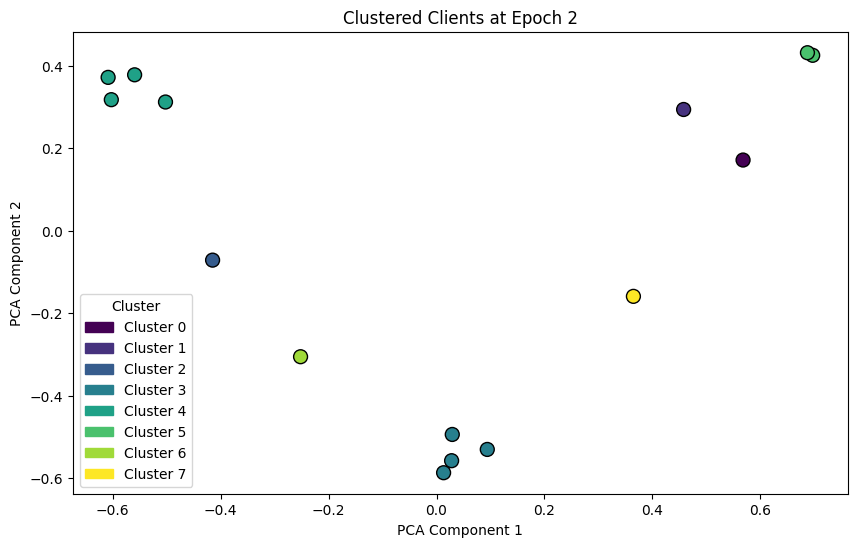

Test set for Client "Global Model": Average loss: 1.8318, Accuracy: 3226/10000 (32%)

============== EPOCH 3 ==============

Test set for Client "Rotation 218 (Group 0-360)": Average loss: 0.4169, Accuracy: 8910/10000 (89%)
Test set for Client "Rotation 168 (Group 0-360)": Average loss: 0.4225, Accuracy: 8882/10000 (89%)
Test set for Client "Rotation 30 (Group 0-360)": Average loss: 0.4171, Accuracy: 8873/10000 (89%)
Test set for Client "Rotation 286 (Group 0-360)": Average loss: 0.5390, Accuracy: 8664/10000 (87%)
Test set for Client "Rotation 358 (Group 0-360)": Average loss: 0.4435, Accuracy: 8823/10000 (88%)
Test set for Client "Rotation 195 (Group 0-360)": Average loss: 0.4194, Accuracy: 8897/10000 (89%)
Test set for Client "Rotation 46 (Group 0-360)": Average loss: 0.4233, Accuracy: 8861/10000 (89%)
Test set for Client "Rotation 9 (Group 0-360)": Average loss: 0.4793, Accuracy: 8755/10000 (88%)
Test set for Client "Rotation 190 (Group 0-360)": Average loss: 0.4227, Accuracy: 8874/

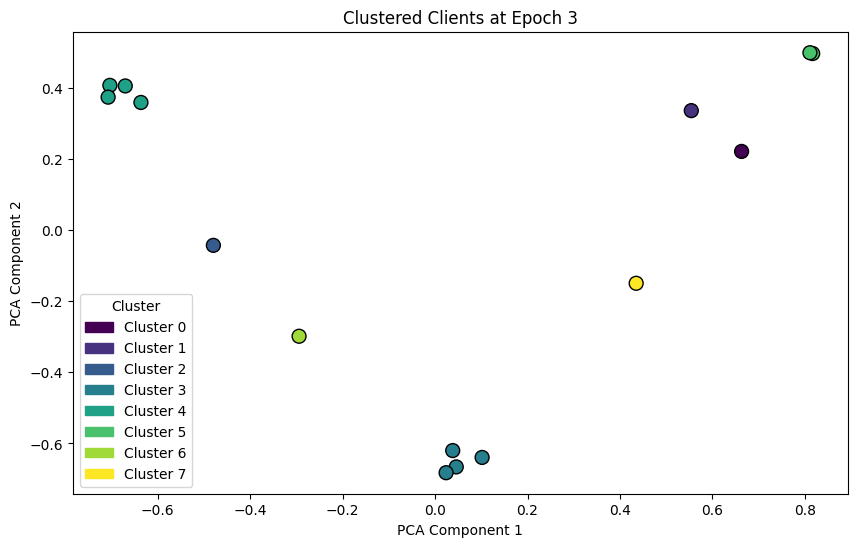

Test set for Client "Global Model": Average loss: 1.8012, Accuracy: 3283/10000 (33%)

============== EPOCH 4 ==============

Test set for Client "Rotation 218 (Group 0-360)": Average loss: 0.3612, Accuracy: 9020/10000 (90%)
Test set for Client "Rotation 168 (Group 0-360)": Average loss: 0.3662, Accuracy: 8992/10000 (90%)
Test set for Client "Rotation 30 (Group 0-360)": Average loss: 0.3609, Accuracy: 8992/10000 (90%)
Test set for Client "Rotation 286 (Group 0-360)": Average loss: 0.4898, Accuracy: 8741/10000 (87%)
Test set for Client "Rotation 358 (Group 0-360)": Average loss: 0.3899, Accuracy: 8901/10000 (89%)
Test set for Client "Rotation 195 (Group 0-360)": Average loss: 0.3645, Accuracy: 8990/10000 (90%)
Test set for Client "Rotation 46 (Group 0-360)": Average loss: 0.3684, Accuracy: 8969/10000 (90%)
Test set for Client "Rotation 9 (Group 0-360)": Average loss: 0.4306, Accuracy: 8806/10000 (88%)
Test set for Client "Rotation 190 (Group 0-360)": Average loss: 0.3682, Accuracy: 8994/

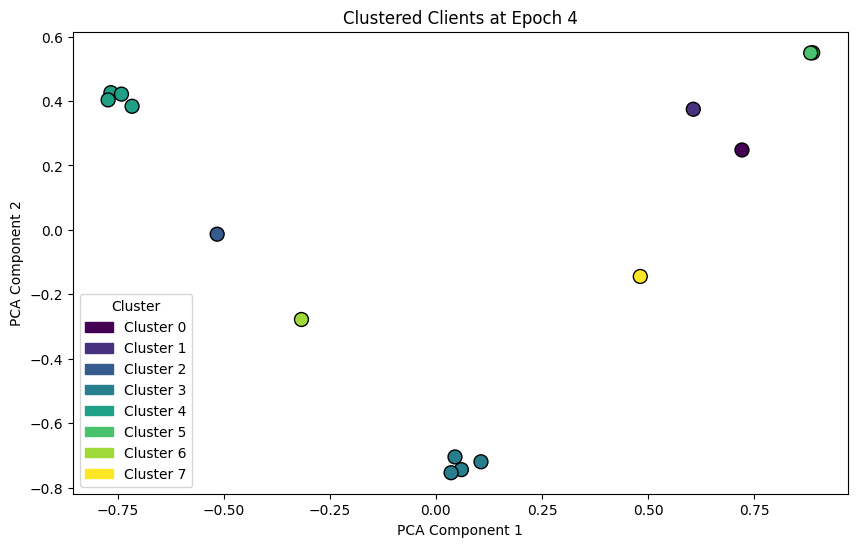

Test set for Client "Global Model": Average loss: 1.7977, Accuracy: 3442/10000 (34%)

============== EPOCH 5 ==============

Test set for Client "Rotation 218 (Group 0-360)": Average loss: 0.3303, Accuracy: 9077/10000 (91%)
Test set for Client "Rotation 168 (Group 0-360)": Average loss: 0.3343, Accuracy: 9065/10000 (91%)
Test set for Client "Rotation 30 (Group 0-360)": Average loss: 0.3303, Accuracy: 9059/10000 (91%)
Test set for Client "Rotation 286 (Group 0-360)": Average loss: 0.4538, Accuracy: 8795/10000 (88%)
Test set for Client "Rotation 358 (Group 0-360)": Average loss: 0.3610, Accuracy: 8948/10000 (89%)
Test set for Client "Rotation 195 (Group 0-360)": Average loss: 0.3355, Accuracy: 9046/10000 (90%)
Test set for Client "Rotation 46 (Group 0-360)": Average loss: 0.3356, Accuracy: 9058/10000 (91%)
Test set for Client "Rotation 9 (Group 0-360)": Average loss: 0.4022, Accuracy: 8858/10000 (89%)
Test set for Client "Rotation 190 (Group 0-360)": Average loss: 0.3366, Accuracy: 9032/

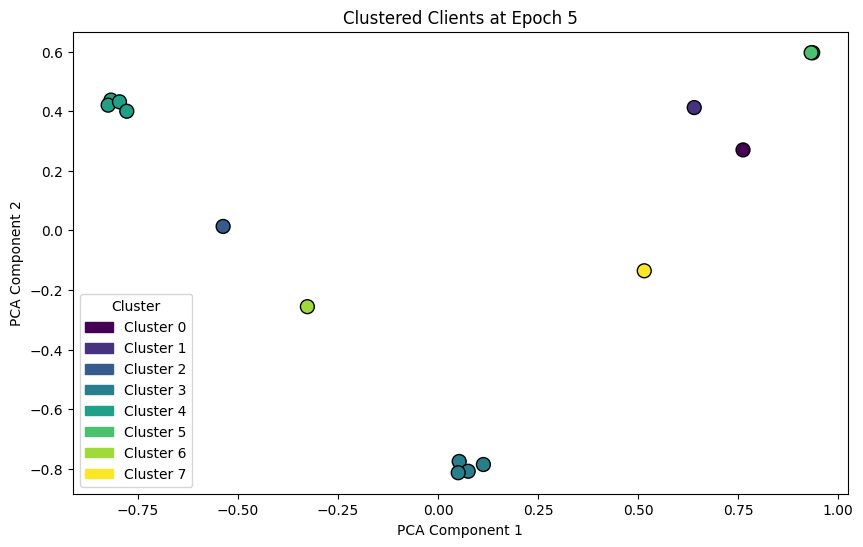

Test set for Client "Global Model": Average loss: 1.7877, Accuracy: 3537/10000 (35%)
Test set for best model / cluster: Average loss: 2.9271, Accuracy: 4799/10000 (48%)


In [22]:
global_model = Net().to(device)
distribute_model(global_model, ALL_CLIENTS)

trainer = DBSCANTrainer(global_model, ALL_CLIENTS, EPOCHS)
trainer.train_all_epochs()

test_best_cluster()


### K-Means Clustering

In [23]:
class KMeansTrainer(AbstractClusteringTrainer):
    def cluster(self, reduced_data):
        kmeans = KMeans(n_clusters=4, random_state=0)
        return kmeans.fit_predict(reduced_data)


============== EPOCH 1 ==============

Test set for Client "Rotation 218 (Group 0-360)": Average loss: 0.9852, Accuracy: 8148/10000 (81%)
Test set for Client "Rotation 168 (Group 0-360)": Average loss: 0.9415, Accuracy: 8133/10000 (81%)
Test set for Client "Rotation 30 (Group 0-360)": Average loss: 0.9544, Accuracy: 8262/10000 (83%)
Test set for Client "Rotation 286 (Group 0-360)": Average loss: 0.9659, Accuracy: 8051/10000 (81%)
Test set for Client "Rotation 358 (Group 0-360)": Average loss: 0.9331, Accuracy: 8240/10000 (82%)
Test set for Client "Rotation 195 (Group 0-360)": Average loss: 0.9418, Accuracy: 8174/10000 (82%)
Test set for Client "Rotation 46 (Group 0-360)": Average loss: 0.9212, Accuracy: 8228/10000 (82%)
Test set for Client "Rotation 9 (Group 0-360)": Average loss: 0.9546, Accuracy: 8228/10000 (82%)
Test set for Client "Rotation 190 (Group 0-360)": Average loss: 0.9572, Accuracy: 8139/10000 (81%)
Test set for Client "Rotation 95 (Group 0-360)": Average loss: 0.9590, Ac

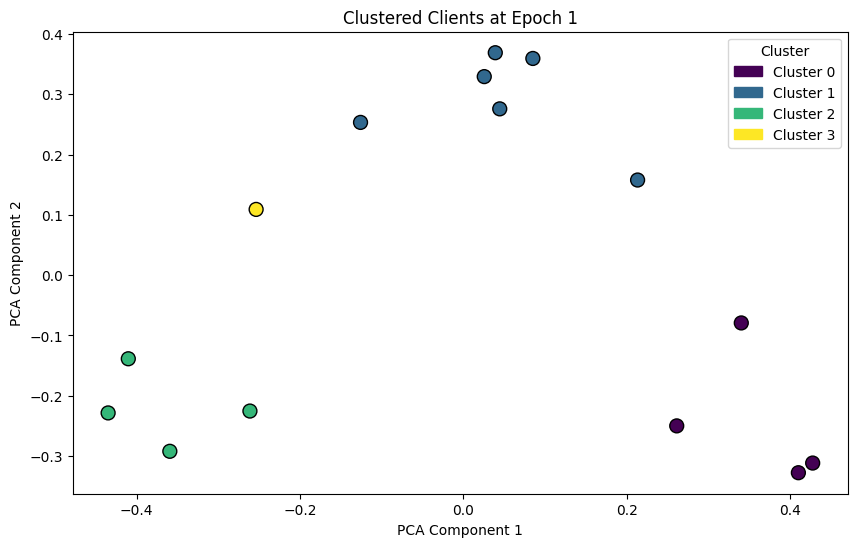

Test set for Client "Global Model": Average loss: 1.9804, Accuracy: 2617/10000 (26%)

============== EPOCH 2 ==============

Test set for Client "Rotation 218 (Group 0-360)": Average loss: 0.5815, Accuracy: 8640/10000 (86%)
Test set for Client "Rotation 168 (Group 0-360)": Average loss: 0.5700, Accuracy: 8579/10000 (86%)
Test set for Client "Rotation 30 (Group 0-360)": Average loss: 0.5230, Accuracy: 8721/10000 (87%)
Test set for Client "Rotation 286 (Group 0-360)": Average loss: 0.6300, Accuracy: 8533/10000 (85%)
Test set for Client "Rotation 358 (Group 0-360)": Average loss: 0.5319, Accuracy: 8717/10000 (87%)
Test set for Client "Rotation 195 (Group 0-360)": Average loss: 0.5379, Accuracy: 8704/10000 (87%)
Test set for Client "Rotation 46 (Group 0-360)": Average loss: 0.6047, Accuracy: 8578/10000 (86%)
Test set for Client "Rotation 9 (Group 0-360)": Average loss: 0.5568, Accuracy: 8650/10000 (86%)
Test set for Client "Rotation 190 (Group 0-360)": Average loss: 0.5366, Accuracy: 8679/

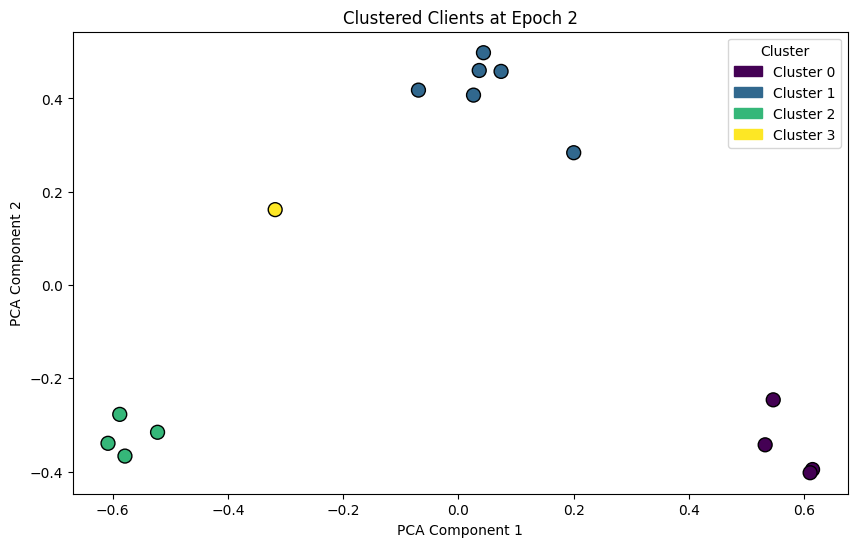

Test set for Client "Global Model": Average loss: 1.8581, Accuracy: 3125/10000 (31%)

============== EPOCH 3 ==============

Test set for Client "Rotation 218 (Group 0-360)": Average loss: 0.4877, Accuracy: 8789/10000 (88%)
Test set for Client "Rotation 168 (Group 0-360)": Average loss: 0.4813, Accuracy: 8713/10000 (87%)
Test set for Client "Rotation 30 (Group 0-360)": Average loss: 0.4098, Accuracy: 8910/10000 (89%)
Test set for Client "Rotation 286 (Group 0-360)": Average loss: 0.5388, Accuracy: 8647/10000 (86%)
Test set for Client "Rotation 358 (Group 0-360)": Average loss: 0.4281, Accuracy: 8866/10000 (89%)
Test set for Client "Rotation 195 (Group 0-360)": Average loss: 0.4261, Accuracy: 8855/10000 (89%)
Test set for Client "Rotation 46 (Group 0-360)": Average loss: 0.5244, Accuracy: 8710/10000 (87%)
Test set for Client "Rotation 9 (Group 0-360)": Average loss: 0.4651, Accuracy: 8803/10000 (88%)
Test set for Client "Rotation 190 (Group 0-360)": Average loss: 0.4262, Accuracy: 8881/

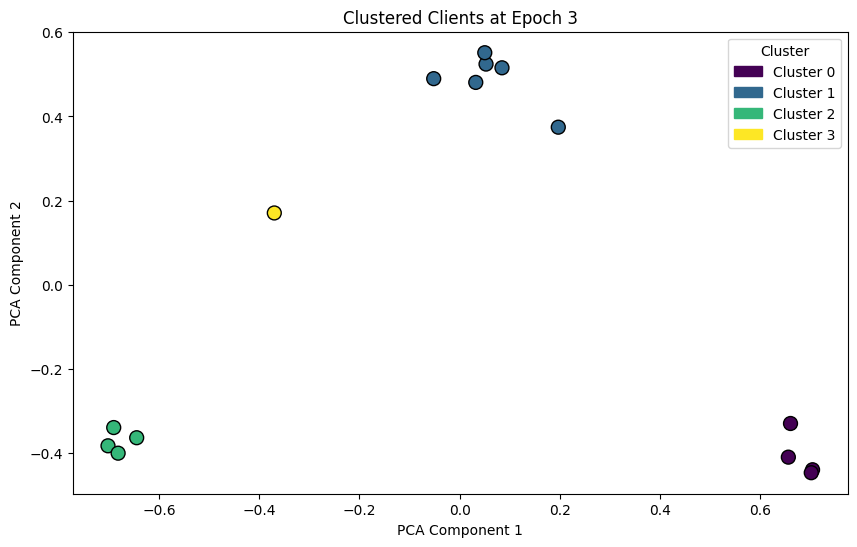

Test set for Client "Global Model": Average loss: 1.7982, Accuracy: 3384/10000 (34%)

============== EPOCH 4 ==============

Test set for Client "Rotation 218 (Group 0-360)": Average loss: 0.4457, Accuracy: 8837/10000 (88%)
Test set for Client "Rotation 168 (Group 0-360)": Average loss: 0.4420, Accuracy: 8770/10000 (88%)
Test set for Client "Rotation 30 (Group 0-360)": Average loss: 0.3569, Accuracy: 9042/10000 (90%)
Test set for Client "Rotation 286 (Group 0-360)": Average loss: 0.4894, Accuracy: 8784/10000 (88%)
Test set for Client "Rotation 358 (Group 0-360)": Average loss: 0.3812, Accuracy: 8959/10000 (90%)
Test set for Client "Rotation 195 (Group 0-360)": Average loss: 0.3754, Accuracy: 8963/10000 (90%)
Test set for Client "Rotation 46 (Group 0-360)": Average loss: 0.4815, Accuracy: 8798/10000 (88%)
Test set for Client "Rotation 9 (Group 0-360)": Average loss: 0.4182, Accuracy: 8864/10000 (89%)
Test set for Client "Rotation 190 (Group 0-360)": Average loss: 0.3740, Accuracy: 8999/

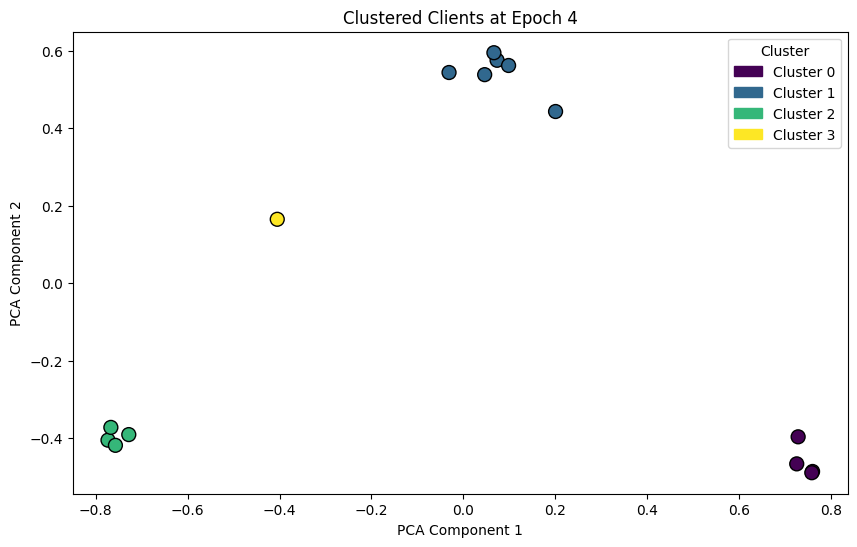

Test set for Client "Global Model": Average loss: 1.7632, Accuracy: 3597/10000 (36%)

============== EPOCH 5 ==============

Test set for Client "Rotation 218 (Group 0-360)": Average loss: 0.4167, Accuracy: 8861/10000 (89%)
Test set for Client "Rotation 168 (Group 0-360)": Average loss: 0.4141, Accuracy: 8827/10000 (88%)
Test set for Client "Rotation 30 (Group 0-360)": Average loss: 0.3233, Accuracy: 9125/10000 (91%)
Test set for Client "Rotation 286 (Group 0-360)": Average loss: 0.4555, Accuracy: 8829/10000 (88%)
Test set for Client "Rotation 358 (Group 0-360)": Average loss: 0.3516, Accuracy: 9015/10000 (90%)
Test set for Client "Rotation 195 (Group 0-360)": Average loss: 0.3427, Accuracy: 9025/10000 (90%)
Test set for Client "Rotation 46 (Group 0-360)": Average loss: 0.4522, Accuracy: 8859/10000 (89%)
Test set for Client "Rotation 9 (Group 0-360)": Average loss: 0.3907, Accuracy: 8915/10000 (89%)
Test set for Client "Rotation 190 (Group 0-360)": Average loss: 0.3452, Accuracy: 9040/

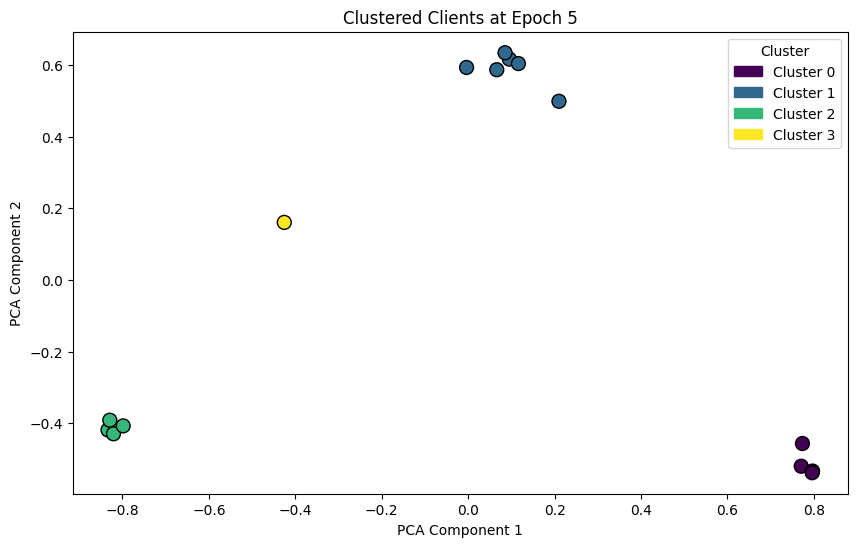

Test set for Client "Global Model": Average loss: 1.7523, Accuracy: 3680/10000 (37%)
Test set for best model / cluster: Average loss: 2.9005, Accuracy: 4393/10000 (44%)


In [24]:
global_model = Net().to(device)
distribute_model(global_model, ALL_CLIENTS)

trainer = KMeansTrainer(global_model, ALL_CLIENTS, EPOCHS)
trainer.train_all_epochs()

test_best_cluster()

### Agglomerative Clustering

In [25]:
class AgglomerativeTrainer(AbstractClusteringTrainer):
    def cluster(self, reduced_data):
        # Using Agglomerative Clustering with a fixed number of clusters (4)
        agglomerative = AgglomerativeClustering(n_clusters=4)
        return agglomerative.fit_predict(reduced_data)


============== EPOCH 1 ==============

Test set for Client "Rotation 218 (Group 0-360)": Average loss: 1.0761, Accuracy: 7998/10000 (80%)
Test set for Client "Rotation 168 (Group 0-360)": Average loss: 1.0980, Accuracy: 8013/10000 (80%)
Test set for Client "Rotation 30 (Group 0-360)": Average loss: 1.0717, Accuracy: 7953/10000 (80%)
Test set for Client "Rotation 286 (Group 0-360)": Average loss: 1.0888, Accuracy: 8055/10000 (81%)
Test set for Client "Rotation 358 (Group 0-360)": Average loss: 1.0815, Accuracy: 7974/10000 (80%)
Test set for Client "Rotation 195 (Group 0-360)": Average loss: 1.0748, Accuracy: 8018/10000 (80%)
Test set for Client "Rotation 46 (Group 0-360)": Average loss: 1.0657, Accuracy: 8035/10000 (80%)
Test set for Client "Rotation 9 (Group 0-360)": Average loss: 1.0764, Accuracy: 7968/10000 (80%)
Test set for Client "Rotation 190 (Group 0-360)": Average loss: 1.0791, Accuracy: 7953/10000 (80%)
Test set for Client "Rotation 95 (Group 0-360)": Average loss: 1.0705, Ac

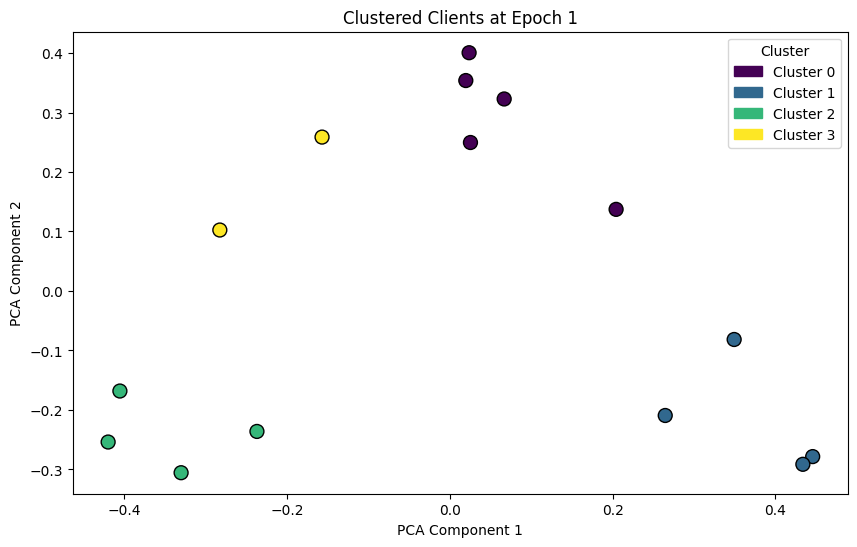

Test set for Client "Global Model": Average loss: 1.9908, Accuracy: 2667/10000 (27%)

============== EPOCH 2 ==============

Test set for Client "Rotation 218 (Group 0-360)": Average loss: 0.6276, Accuracy: 8599/10000 (86%)
Test set for Client "Rotation 168 (Group 0-360)": Average loss: 0.6123, Accuracy: 8555/10000 (86%)
Test set for Client "Rotation 30 (Group 0-360)": Average loss: 0.5784, Accuracy: 8577/10000 (86%)
Test set for Client "Rotation 286 (Group 0-360)": Average loss: 0.6561, Accuracy: 8541/10000 (85%)
Test set for Client "Rotation 358 (Group 0-360)": Average loss: 0.5866, Accuracy: 8575/10000 (86%)
Test set for Client "Rotation 195 (Group 0-360)": Average loss: 0.5834, Accuracy: 8640/10000 (86%)
Test set for Client "Rotation 46 (Group 0-360)": Average loss: 0.5779, Accuracy: 8609/10000 (86%)
Test set for Client "Rotation 9 (Group 0-360)": Average loss: 0.6173, Accuracy: 8553/10000 (86%)
Test set for Client "Rotation 190 (Group 0-360)": Average loss: 0.5792, Accuracy: 8671/

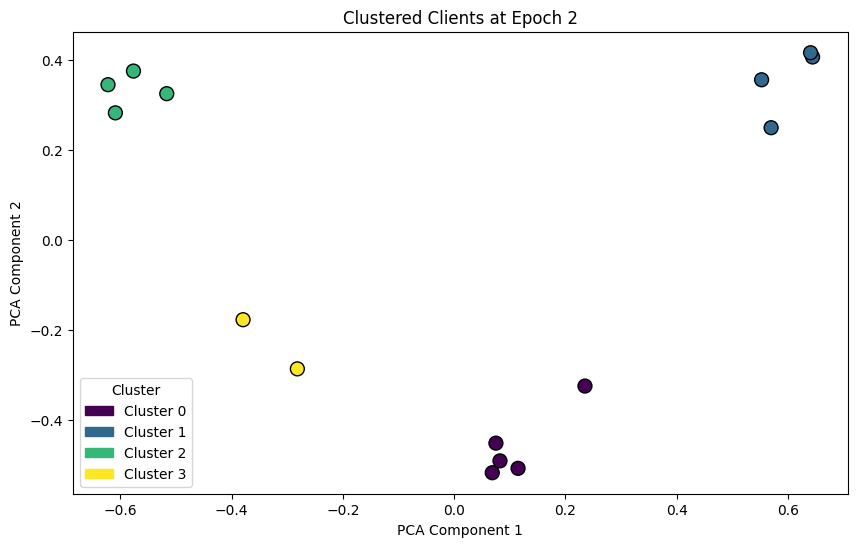

Test set for Client "Global Model": Average loss: 1.8393, Accuracy: 3046/10000 (30%)

============== EPOCH 3 ==============

Test set for Client "Rotation 218 (Group 0-360)": Average loss: 0.5122, Accuracy: 8708/10000 (87%)
Test set for Client "Rotation 168 (Group 0-360)": Average loss: 0.5046, Accuracy: 8687/10000 (87%)
Test set for Client "Rotation 30 (Group 0-360)": Average loss: 0.4523, Accuracy: 8823/10000 (88%)
Test set for Client "Rotation 286 (Group 0-360)": Average loss: 0.5483, Accuracy: 8672/10000 (87%)
Test set for Client "Rotation 358 (Group 0-360)": Average loss: 0.4547, Accuracy: 8829/10000 (88%)
Test set for Client "Rotation 195 (Group 0-360)": Average loss: 0.4506, Accuracy: 8855/10000 (89%)
Test set for Client "Rotation 46 (Group 0-360)": Average loss: 0.4475, Accuracy: 8833/10000 (88%)
Test set for Client "Rotation 9 (Group 0-360)": Average loss: 0.4963, Accuracy: 8731/10000 (87%)
Test set for Client "Rotation 190 (Group 0-360)": Average loss: 0.4470, Accuracy: 8826/

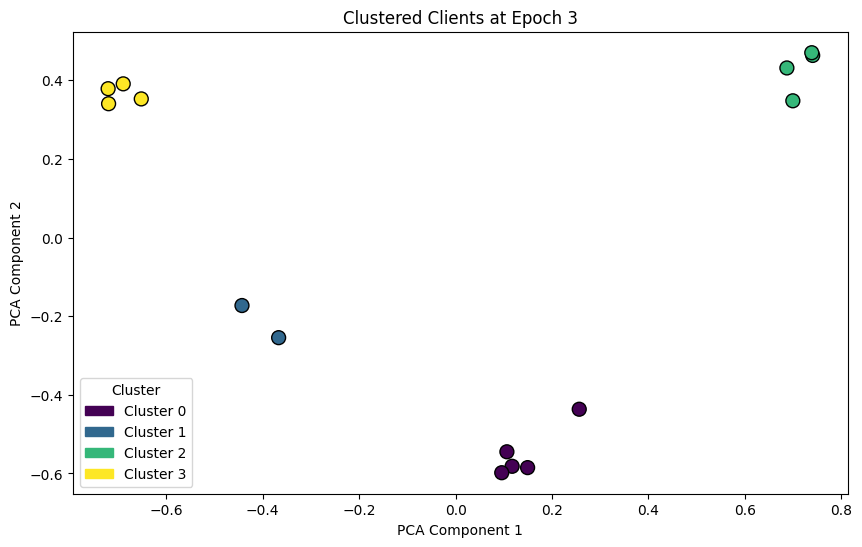

Test set for Client "Global Model": Average loss: 1.7953, Accuracy: 3246/10000 (32%)

============== EPOCH 4 ==============

Test set for Client "Rotation 218 (Group 0-360)": Average loss: 0.4620, Accuracy: 8767/10000 (88%)
Test set for Client "Rotation 168 (Group 0-360)": Average loss: 0.4597, Accuracy: 8741/10000 (87%)
Test set for Client "Rotation 30 (Group 0-360)": Average loss: 0.3933, Accuracy: 8919/10000 (89%)
Test set for Client "Rotation 286 (Group 0-360)": Average loss: 0.4961, Accuracy: 8754/10000 (88%)
Test set for Client "Rotation 358 (Group 0-360)": Average loss: 0.3998, Accuracy: 8914/10000 (89%)
Test set for Client "Rotation 195 (Group 0-360)": Average loss: 0.3889, Accuracy: 8951/10000 (90%)
Test set for Client "Rotation 46 (Group 0-360)": Average loss: 0.3884, Accuracy: 8930/10000 (89%)
Test set for Client "Rotation 9 (Group 0-360)": Average loss: 0.4396, Accuracy: 8804/10000 (88%)
Test set for Client "Rotation 190 (Group 0-360)": Average loss: 0.3902, Accuracy: 8956/

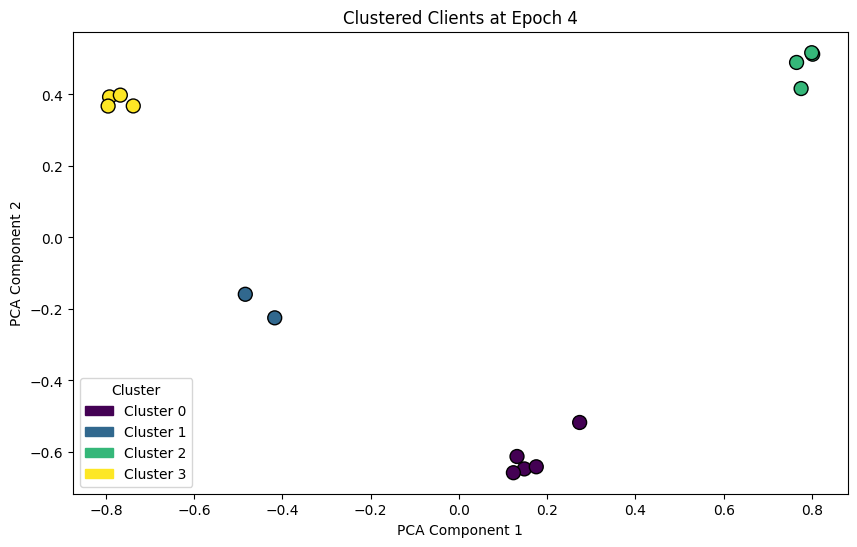

Test set for Client "Global Model": Average loss: 1.7835, Accuracy: 3383/10000 (34%)

============== EPOCH 5 ==============

Test set for Client "Rotation 218 (Group 0-360)": Average loss: 0.4326, Accuracy: 8804/10000 (88%)
Test set for Client "Rotation 168 (Group 0-360)": Average loss: 0.4329, Accuracy: 8775/10000 (88%)
Test set for Client "Rotation 30 (Group 0-360)": Average loss: 0.3619, Accuracy: 8971/10000 (90%)
Test set for Client "Rotation 286 (Group 0-360)": Average loss: 0.4598, Accuracy: 8812/10000 (88%)
Test set for Client "Rotation 358 (Group 0-360)": Average loss: 0.3645, Accuracy: 8980/10000 (90%)
Test set for Client "Rotation 195 (Group 0-360)": Average loss: 0.3559, Accuracy: 9013/10000 (90%)
Test set for Client "Rotation 46 (Group 0-360)": Average loss: 0.3550, Accuracy: 8994/10000 (90%)
Test set for Client "Rotation 9 (Group 0-360)": Average loss: 0.4082, Accuracy: 8857/10000 (89%)
Test set for Client "Rotation 190 (Group 0-360)": Average loss: 0.3546, Accuracy: 9011/

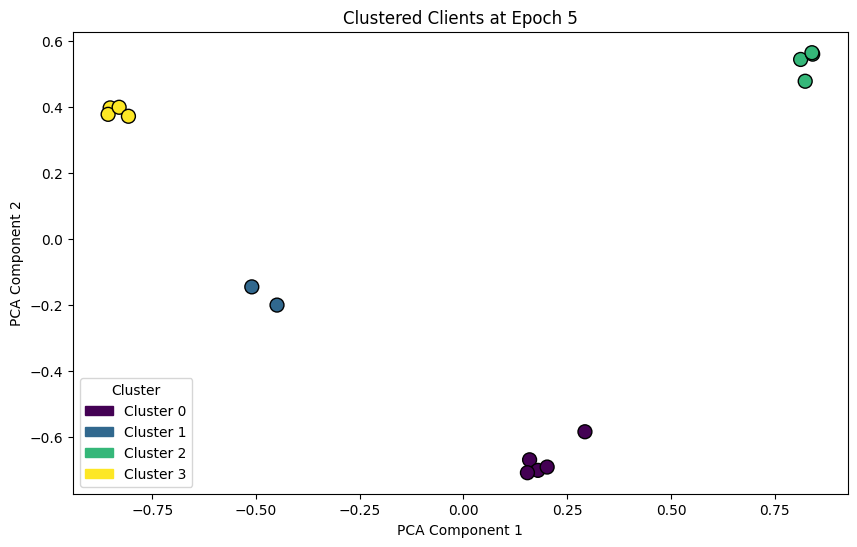

Test set for Client "Global Model": Average loss: 1.7658, Accuracy: 3412/10000 (34%)
Test set for best model / cluster: Average loss: 2.8515, Accuracy: 4445/10000 (44%)


In [26]:
global_model = Net().to(device)
distribute_model(global_model, ALL_CLIENTS)

trainer = AgglomerativeTrainer(global_model, ALL_CLIENTS, EPOCHS)
trainer.train_all_epochs()

test_best_cluster()

### No Clustering

In [27]:
class NoClusterTrainer(AbstractClusteringTrainer):
    def cluster(self, reduced_data):
        pass

In [28]:
global_model = Net().to(device)
distribute_model(global_model, ALL_CLIENTS)

trainer = NoClusterTrainer(global_model, ALL_CLIENTS, EPOCHS, dont_cluster=True)
trainer.train_all_epochs()


============== EPOCH 1 ==============

Test set for Client "Rotation 218 (Group 0-360)": Average loss: 0.9671, Accuracy: 8179/10000 (82%)
Test set for Client "Rotation 168 (Group 0-360)": Average loss: 0.9713, Accuracy: 8092/10000 (81%)
Test set for Client "Rotation 30 (Group 0-360)": Average loss: 0.9520, Accuracy: 8183/10000 (82%)
Test set for Client "Rotation 286 (Group 0-360)": Average loss: 0.9960, Accuracy: 8096/10000 (81%)
Test set for Client "Rotation 358 (Group 0-360)": Average loss: 0.9744, Accuracy: 8117/10000 (81%)
Test set for Client "Rotation 195 (Group 0-360)": Average loss: 0.9642, Accuracy: 8133/10000 (81%)
Test set for Client "Rotation 46 (Group 0-360)": Average loss: 0.9189, Accuracy: 8181/10000 (82%)
Test set for Client "Rotation 9 (Group 0-360)": Average loss: 0.9865, Accuracy: 8059/10000 (81%)
Test set for Client "Rotation 190 (Group 0-360)": Average loss: 0.9675, Accuracy: 8106/10000 (81%)
Test set for Client "Rotation 95 (Group 0-360)": Average loss: 0.9410, Ac